#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

*В реализации данной функции нет ничего нетривиального, просто используем библотечные методы numpy для работы с матрицами и векторами*

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
  N = len(X)
  L = 0
  for i in range(N):
    L += np.log(1 + np.exp(-y[i] * (np.dot(w, X[i]) + w0)))
  return L / N + gamma * np.sum(np.abs(w)) + beta * np.sum(w ** 2)

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

*Тут также, пользуясь верхними формулами, прописываем через numpy, но дление заменяем операцией возведения экспоненты в степень логарифма (основное логарифмическое тождество)*

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    N = len(X)
    grad_w = - 1 / N * (np.dot(X.T, y * np.exp(-np.logaddexp(0, y * (np.dot(X, w) + w0))))) + gamma * np.sign(w) + 2 * beta * w
    grad_w0 = - 1 / N * np.sum(y * np.exp(-np.logaddexp(0, y * (np.dot(X, w) + w0))))
    return grad_w, grad_w0

In [4]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

In [5]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

*Проверяем работу*

In [6]:
loss(X, y, w, w0)

np.float64(5.607743900541797)

In [7]:
get_grad(X, y, w, w0)

(array([-2.73262181, -1.87176392,  1.30051023,  2.53598816, -2.71198278]),
 np.float64(-0.20782319347690748))

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

*У меня представлен стохастический GD, который повторяет выбирая каждый раз случайный объект (не по бэтчам). В init инициилизируем все переменные, которые поступают на вход, а также loss_history, которая пригодится в последующем для построения графика изменнеия функции потерь от номера итерации. Затем в методе fit происходит само обучение. Вначале определяем количество фичей и признаков, инициализируем нулями наш вектор весов и смещение. Затем заходим в цикл, там мы с каждой итерацией понижаем нашу скорость обучения и сохраняем предыдущие значения для проверки условия продолжения расчета, а также случайную перестановку индексов благодаря которой будем всё время брать случайный индекс. Дальше мы просто вычисляем w и w0 внутри каждой эпохи и проверяем разность w^t - w^(t-1) < E, если True, то заканчиваем обучание. В predict возвращаем метки 0/1, а в predict_proba возвращаем вероятности*

In [8]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [9]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.loss_history = []

    def fit(self, X, y):
        N, K = X.shape
        rng = np.random.RandomState(self.random_state)
        self.w = np.zeros(K, dtype=np.float64)
        self.w0 = 0.0
        for epoch in range(self.max_iter):
            if epoch != 0:
                lr_t = self.lr / epoch ** 0.3
            else:
                lr_t = self.lr
            w_old = self.w.copy()
            w0_old = self.w0
            order = rng.permutation(N)
            for i in order:
                xi = X[i:i+1]
                yi = y[i:i+1]
                grad_w, grad_w0 = get_grad(xi, yi, self.w, self.w0, gamma=self.gamma, beta=self.beta)
                self.w -= lr_t * grad_w
                self.w0 -= lr_t * grad_w0
            self.loss_history.append(loss(X, y, self.w, self.w0, gamma=self.gamma, beta=self.beta))
            if np.linalg.norm(self.w - w_old) < self.tolerance:
                break
        return self

    def predict(self, X):
        linear = np.dot(X, self.w) + self.w0
        probs = np.exp(-np.logaddexp(0, -linear))
        return np.where(probs >= 0.5, 1, 0)

    def predict_proba(self, X):
        linear = np.dot(X, self.w) + self.w0
        probs = np.exp(-np.logaddexp(0, -linear))
        return probs

In [10]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [11]:
def plot_decision_boundary(model, X, y):
    plt.figure(figsize=(10, 8))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], colors=['#FFAAAA', '#AAAAFF'], alpha=0.3)
    plt.contour(xx, yy, Z, levels=[0.5], colors='red', linewidths=2)
    class_neg = X[y == -1]
    class_pos = X[y == 1]
    plt.scatter(class_neg[:, 0], class_neg[:, 1], color='black', marker='o', label='class 0', s=50)
    plt.scatter(class_pos[:, 0], class_pos[:, 1], color='white', edgecolors='black', marker='s', label='class 1', s=50)

    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

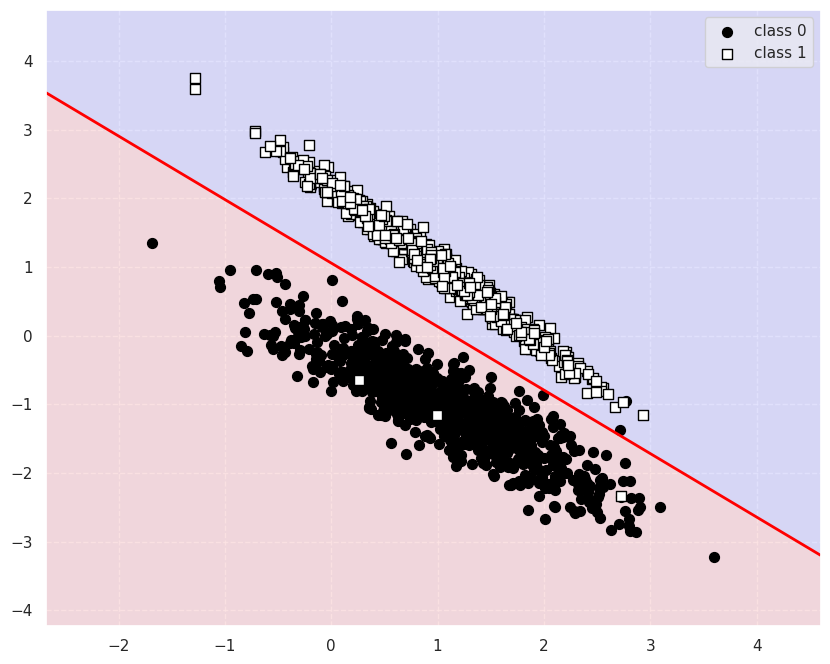

In [ ]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

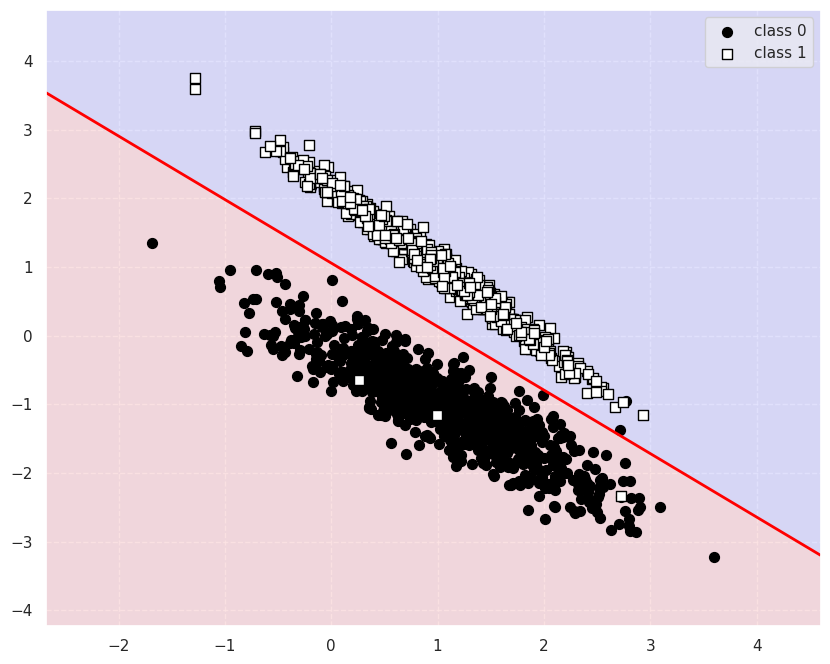

In [ ]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

*Именно для этого графика мы добавили в Logit переменную loss_history*

In [ ]:
def plot_loss_history(model):
    plt.figure(figsize=(8,6))
    plt.plot(model.loss_history, marker='o')
    plt.xlabel('Итерация')
    plt.ylabel('Ф-я потерь')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


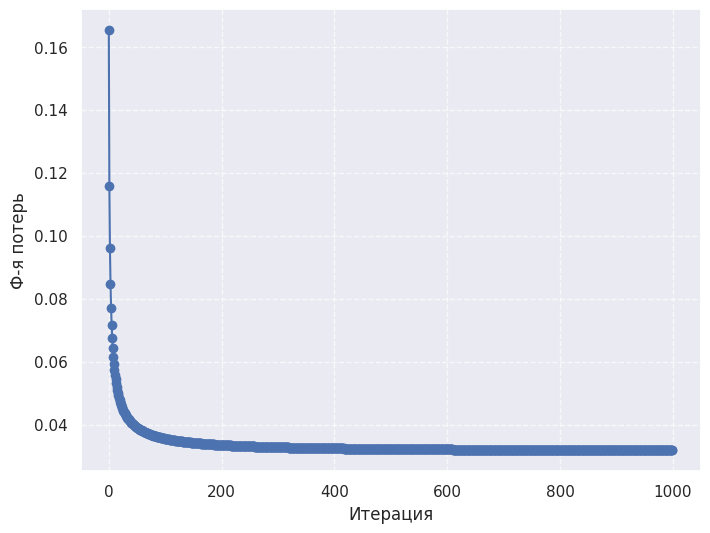

In [ ]:
plot_loss_history(model)

#### 6. [1 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C_val = [0.0001, 0.1, 1, 10, 100, 10000]

results = []

for kernel in kernels:
    for C in C_val:
        model = SVC(kernel=kernel, C=C, probability=True, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]

        results.append({
            'kernel': kernel,
            'C': C,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, pos_label=1),
            'Recall': recall_score(y_test, y_pred, pos_label=1),
            'F1-Score': f1_score(y_test, y_pred, pos_label=1),
            'AUC-ROC': roc_auc_score(y_test, y_proba)
        })

print(pd.DataFrame(results))

     kernel           C  Accuracy  Precision    Recall  F1-Score   AUC-ROC
0    linear      0.0001  0.481481   0.481481  1.000000  0.650000  0.974446
1    linear      0.1000  0.993266   0.989583  0.996503  0.993031  0.998785
2    linear      1.0000  0.993266   0.989583  0.996503  0.993031  0.999024
3    linear     10.0000  0.993266   0.989583  0.996503  0.993031  0.998763
4    linear    100.0000  0.993266   0.989583  0.996503  0.993031  0.998729
5    linear  10000.0000  0.993266   0.989583  0.996503  0.993031  0.998694
6      poly      0.0001  0.510101   0.495652  0.996503  0.662021  0.942864
7      poly      0.1000  0.994949   0.993031  0.996503  0.994764  0.994210
8      poly      1.0000  0.994949   0.993031  0.996503  0.994764  0.994948
9      poly     10.0000  0.994949   0.993031  0.996503  0.994764  0.994562
10     poly    100.0000  0.994949   0.993031  0.996503  0.994764  0.994812
11     poly  10000.0000  0.994949   0.993031  0.996503  0.994764  0.994801
12      rbf      0.0001  

*При малом C все ядра дают низкое качество, так как не происходит обучение из-за такого низкого С. При более высоких С метрики имеют адекватные значения. Ядра по сути похожи - для каждого при самом малом С accuracy и precision ~0.5, а F1-score ~0.65, но для сигмоида на всех метриках меньше качество.*

#### 6.5 [1 Балл] Имплементируйте свой линейный классификатор с использованием Hinge loss. Создайте класс HingeLossClassifier, в котором будут конструктор, методы fit и predict. Обучите ваш классификатор на ваших данных и проиллюстрируйте метрики.

*Метод _hinge_loss... как раз вычисляет значение функции потерь и градиенты для каждого бэтча. Также штрафует ошибки, где точки попадают не туда. В fit стохастический GD как и в Logit. Из decision_function мы получим расстояние до гиперплоскости, predict это метрики 0/1, score это точность*

In [ ]:
class HingeLossClassifier:
    def __init__(self, lr=1e-2, lambda_reg=1e-3, n_epochs=100, batch_size=32, random_state=42, verbose=False):
        self.lr = lr
        self.lambda_reg = lambda_reg
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.random_state = random_state
        self.verbose = verbose
        self.w = None
        self.w0 = 0.0
        self.loss_history = []

    def _hinge_loss_and_grad_batch(self, Xb, yb):
        B = Xb.shape[0]
        scores = Xb.dot(self.w) + self.w0
        margins = yb * scores
        mask = margins < 1.0
        hinge_vals = np.maximum(0.0, 1.0 - margins)
        loss = hinge_vals.mean() + self.lambda_reg * (self.w @ self.w)
        grad_w = np.zeros_like(self.w)
        grad_w0 = 0.0
        if mask.any():
            grad_w = - (yb[mask, None] * Xb[mask]).sum(axis=0) / B
            grad_w0 = - yb[mask].sum() / B
        grad_w += 2.0 * self.lambda_reg * self.w
        return loss, grad_w, grad_w0

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)
        if set(np.unique(y)) <= {0, 1}:
            y = 2 * y - 1
        N, K = X.shape
        self.w = np.zeros(K)
        self.w0 = 0.0
        self.loss_history = []
        for epoch in range(1, self.n_epochs + 1):
            order = rng.permutation(N)
            if epoch != 0:
                lr_t = self.lr / (epoch ** 0.3)
            else:
                lr_t = self.lr
            for start in range(0, N, self.batch_size):
                idx = order[start:start + self.batch_size]
                Xb = X[idx]
                yb = y[idx]
                loss_b, grad_w, grad_w0 = self._hinge_loss_and_grad_batch(Xb, yb)
                self.w -= lr_t * grad_w
                self.w0 -= lr_t * grad_w0
            scores_all = X.dot(self.w) + self.w0
            margins_all = y * scores_all
            loss_epoch = np.maximum(0.0, 1.0 - margins_all).mean() + self.lambda_reg * (self.w @ self.w)
            self.loss_history.append(loss_epoch)
        return self

    def decision_function(self, X):
        return X.dot(self.w) + self.w0

    def predict(self, X):
        return (self.decision_function(X) >= 0).astype(int)

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

*Перед этим кодом нужно перезапускать код :* # этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2, random_state=42, n_clusters_per_class=1)
*Не знаю почему (возможно я случайно где-то его меняю)*

Accuracy: 0.9949494949494949
Precision: 0.9933554817275747
Recall: 0.9966666666666667
F1: 0.9950083194675541


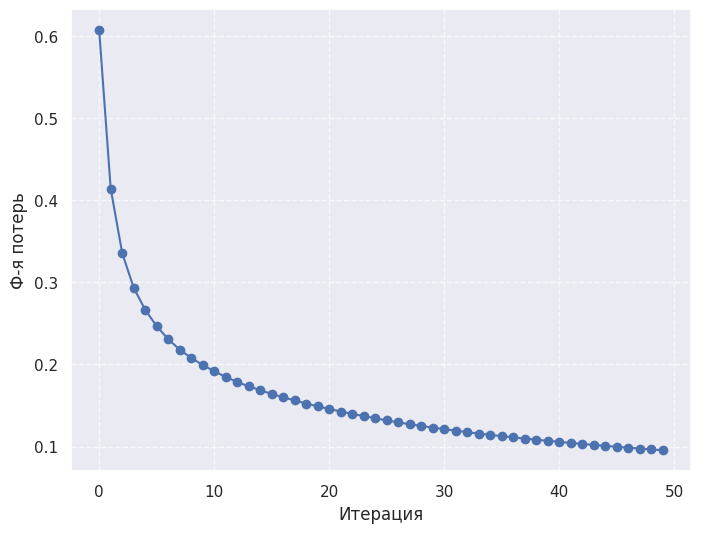

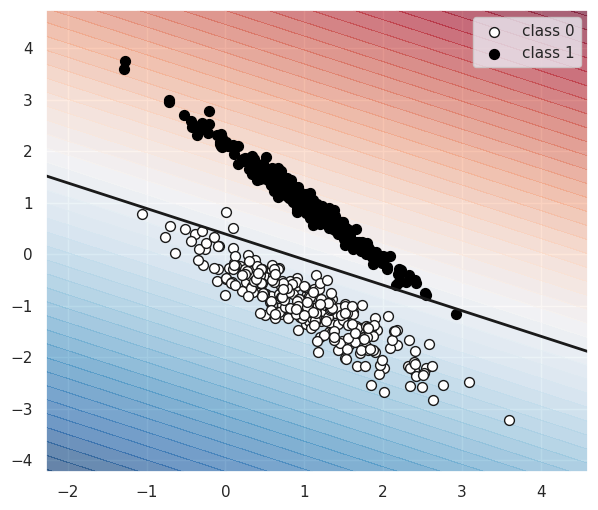

In [ ]:
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

clf = HingeLossClassifier(lr=0.01, lambda_reg=1e-3, n_epochs=50, batch_size=32, verbose=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, pos_label=1))
print("Recall:", recall_score(y_test, y_pred, pos_label=1))
print("F1:", f1_score(y_test, y_pred, pos_label=1))

plot_loss_history(clf)

x_min, x_max = X_test[:,0].min()-1, X_test[:,0].max()+1
y_min, y_max = X_test[:,1].min()-1, X_test[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
df = clf.decision_function(grid).reshape(xx.shape)
plt.figure(figsize=(7,6))
plt.contourf(xx, yy, df, levels=50, cmap='RdBu_r', alpha=0.6)
plt.contour(xx, yy, df, levels=[0.0], colors='k', linewidths=2)
plt.scatter(X_test[y_test==0,0], X_test[y_test==0,1], c='white', edgecolors='k', label='class 0', s=50)
plt.scatter(X_test[y_test==1,0], X_test[y_test==1,1], c='black', label='class 1', s=50)
plt.legend()
plt.show()


#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

*В fit определяем, помимо обучающих данных и меток, уникальные классы. В predict вычисляем расстояние до всех обучающих объектов и получает класс, который чаще всего из соседей. В predict_proba возвращаем уже вероятности для класса*

In [ ]:
from scipy.spatial.distance import euclidean

class KNNClassifier:
    def __init__(self, n_neighbors=5, metric=euclidean):
        self.n_neighbors = n_neighbors
        self.metric = metric

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.classes_ = np.unique(y)
        self.class_to_index = {c: i for i, c in enumerate(self.classes_)}

    def predict(self, X):
        y_pred = []
        for entry in X:
            distances = np.array([self.metric(entry, x_train) for x_train in self.X_train])
            neighbors_idx = np.argsort(distances)[:self.n_neighbors]
            neighbors_labels = self.y_train[neighbors_idx]
            neighbors_labels_idx = np.array([self.class_to_index[l] for l in neighbors_labels])
            counts = np.bincount(neighbors_labels_idx)
            y_pred.append(self.classes_[counts.argmax()])
        return np.array(y_pred)

    def predict_proba(self, X):
        probas = []
        for entry in X:
            distances = np.array([self.metric(entry, x_train) for x_train in self.X_train])
            neighbors_idx = np.argsort(distances)[:self.n_neighbors]
            neighbors_labels = self.y_train[neighbors_idx]
            class_counts = np.array([np.sum(neighbors_labels == c) for c in self.classes_])
            probas.append(class_counts / self.n_neighbors)
        return np.array(probas)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Neighbors = [1, 2, 3, 5, 10, 20, 30, 50, 100]
results = []

for neighbors in Neighbors:
    knn = KNNClassifier(n_neighbors=neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    y_proba = knn.predict_proba(X_test)[:,1]

    results.append({
        'neighbors': neighbors,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, pos_label=1),
        'Recall': recall_score(y_test, y_pred, pos_label=1),
        'F1-Score': f1_score(y_test, y_pred, pos_label=1),
        'AUC-ROC': roc_auc_score(y_test, y_proba)
    })

print(pd.DataFrame(results))


   neighbors  Accuracy  Precision    Recall  F1-Score   AUC-ROC
0          1  0.991582   0.986159  0.996503  0.991304  0.991758
1          2  0.991582   0.989547  0.993007  0.991274  0.993353
2          3  0.993266   0.989583  0.996503  0.993031  0.994948
3          5  0.993266   0.989583  0.996503  0.993031  0.994914
4         10  0.994949   0.993031  0.996503  0.994764  0.994852
5         20  0.994949   0.993031  0.996503  0.994764  0.996401
6         30  0.994949   0.993031  0.996503  0.994764  0.996203
7         50  0.996633   0.996503  0.996503  0.996503  0.996061
8        100  0.993266   0.996479  0.989510  0.992982  0.995453


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fash_mints_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fashion-mnist_test.csv', sep=',')
fash_mints_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fashion-mnist_train.csv', sep=',')

In [ ]:
#0 T-shirt/top 1 Trouser 2 Pullover 3 Dress 4 Coat 5 Sandal 6 Shirt 7 Sneaker 8 Bag 9 Ankle boot
fash_mints_test

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,32,23,14,20,0,0,1,0,0,0
9996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,2,52,23,28,0,0,0
9997,8,0,0,0,0,0,0,0,0,0,...,175,172,172,182,199,222,42,0,1,0
9998,8,0,1,3,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

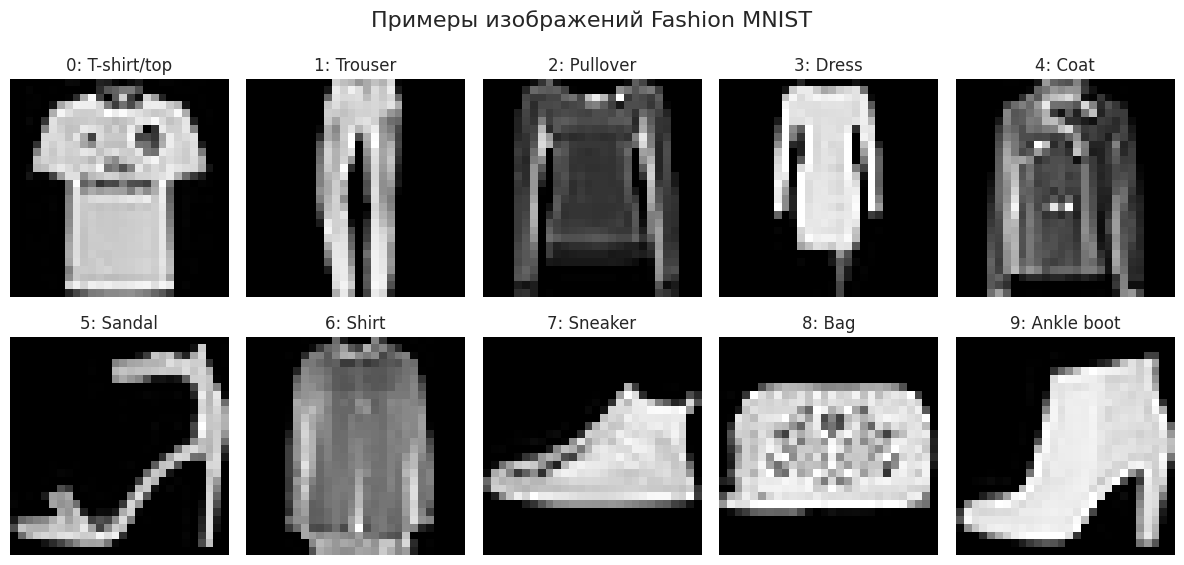

In [ ]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(12, 6))
unique_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

for i, label in enumerate(unique_labels):
    img = fash_mints_test[fash_mints_test['label'] == label].iloc[0, 1:].to_numpy()
    img = img.reshape(28, 28)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{label}: {class_names[label]}")
    plt.axis('off')

plt.suptitle("Примеры изображений Fashion MNIST", fontsize=16)
plt.tight_layout()
plt.show()

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
from sklearn.preprocessing import StandardScaler
Xx = fash_mints_test.drop('label', axis=1).values
scaler_std = StandardScaler()
X_std = scaler_std.fit_transform(Xx)
print("Среднее после нормализации:", np.mean(X_std))
print("Стандартное отклонение:", np.std(X_std))


Среднее после нормализации: 3.617741027385689e-18
Стандартное отклонение: 1.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler_mm = MinMaxScaler()
X_mm = scaler_mm.fit_transform(Xx)
print("Минимум после нормализации:", np.min(X_mm))
print("Максимум после нормализации:", np.max(X_mm))


Минимум после нормализации: 0.0
Максимум после нормализации: 1.0


#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

*Это работает ОООЧЕНЬ долго если брать трейн и тест из полного датасета, поэтому я взял только часть для ускорения просмотра. Но и это не помогло и оно бежало 1.5 часа на логреге и не собиралось останавливаться. Не знаю в чем проблема, возьму искуственную выборку, просто для визуализации работы кода.*

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_clusters_per_class=1,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=42, max_iter=2000))
])

knn_params = {
    'knn__n_neighbors': [1, 5, 7, 10, 20],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

lr_params = {
    'lr__C': [0.001, 1, 100],
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear', 'saga']
}

print("Подбор параметров для KNeighborsClassifier...")
knn_gs = GridSearchCV(knn_pipeline, knn_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
knn_gs.fit(X_train, y_train)

print("\nПодбор параметров для LogisticRegression...")
lr_gs = GridSearchCV(lr_pipeline, lr_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
lr_gs.fit(X_train, y_train)

knn_pred = knn_gs.predict(X_test)
lr_pred = lr_gs.predict(X_test)

knn_accuracy = accuracy_score(y_test, knn_pred)
lr_accuracy = accuracy_score(y_test, lr_pred)

print(f"KNeighborsClassifier - Accuracy: {knn_accuracy:.4f}")
print(f"Лучшие параметры KNN: {knn_gs.best_params_}")

print(f"\nLogisticRegression - Accuracy: {lr_accuracy:.4f}")
print(f"Лучшие параметры LR: {lr_gs.best_params_}")

Подбор параметров для KNeighborsClassifier...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Подбор параметров для LogisticRegression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
KNeighborsClassifier - Accuracy: 0.9750
Лучшие параметры KNN: {'knn__metric': 'euclidean', 'knn__n_neighbors': 10, 'knn__weights': 'uniform'}

LogisticRegression - Accuracy: 0.9800
Лучшие параметры LR: {'lr__C': 1, 'lr__penalty': 'l1', 'lr__solver': 'saga'}


*Для KNN основное это количество соседей, важно взять правильное количество чтобы не было переобучения и избежать вариативности, метрика расстояния и веса примерно равны по значимости, то есть weights определяет кто имеет больше вес ближние/дальние соседи, а metric отвечает за расчёт расстояние, то есть определения кто ближайший сосед.*
*Для LogReg основными являются С, который контролирует силу регуляризации,solver, который определеяет какой алгоритм оптимизации используем, также penalty, который определяет тип регуляризации.*

In [ ]:
X_full = fash_mints_train.drop(columns=['label']).values.astype(np.float32)
y_full = fash_mints_train['label'].values.astype(int)
X_test_full = fash_mints_test.drop(columns=['label']).values.astype(np.float32)
y_test_full = fash_mints_test['label'].values.astype(int)

n_train = 800
n_test  = 200

X_train, _, y_train, _ = train_test_split(
    X_full, y_full, train_size=n_train, stratify=y_full, random_state=42
)

X_test, _, y_test, _ = train_test_split(
    X_test_full, y_test_full, train_size=n_test, stratify=y_test_full, random_state=42
)

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=42, max_iter=2000))
])

knn_params = {
    'knn__n_neighbors': [1, 5, 7, 10, 20],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

lr_params = {
    'lr__C': [0.001, 1, 100],
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear', 'saga']
}

print("Подбор параметров для KNeighborsClassifier...")
knn_gs = GridSearchCV(knn_pipeline, knn_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
knn_gs.fit(X_train, y_train)

print("\nПодбор параметров для LogisticRegression...")
lr_gs = GridSearchCV(lr_pipeline, lr_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
lr_gs.fit(X_train, y_train)

knn_pred = knn_gs.predict(X_test)
lr_pred = lr_gs.predict(X_test)

knn_accuracy = accuracy_score(y_test, knn_pred)
lr_accuracy = accuracy_score(y_test, lr_pred)

print(f"KNeighborsClassifier - Accuracy: {knn_accuracy:.4f}")
print(f"Лучшие параметры KNN: {knn_gs.best_params_}")

print(f"\nLogisticRegression - Accuracy: {lr_accuracy:.4f}")
print(f"Лучшие параметры LR: {lr_gs.best_params_}")

Подбор параметров для KNeighborsClassifier...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

*Напишем код, который реализует нашу картинку, для ускорения работы буду использовать не по 5000, а по 500:)*

In [ ]:
N = 1000
K = 2
X_x = np.ones((N, K))
y_y = np.array([0]*500 + [1]*500)

model = Logit()
model.fit(X_x, y_y)

# предсказания
y_pred = model.predict(X_x)

# accuracy
accuracy = np.mean(y_pred == y_y)
print("Accuracy:", accuracy)

Accuracy: 0.5


*Видим акураси 0.5, что и логично. У
нас и трэйн и тест абсолютно
одинаковы. По сути у нас все точки находятся в одной точке*

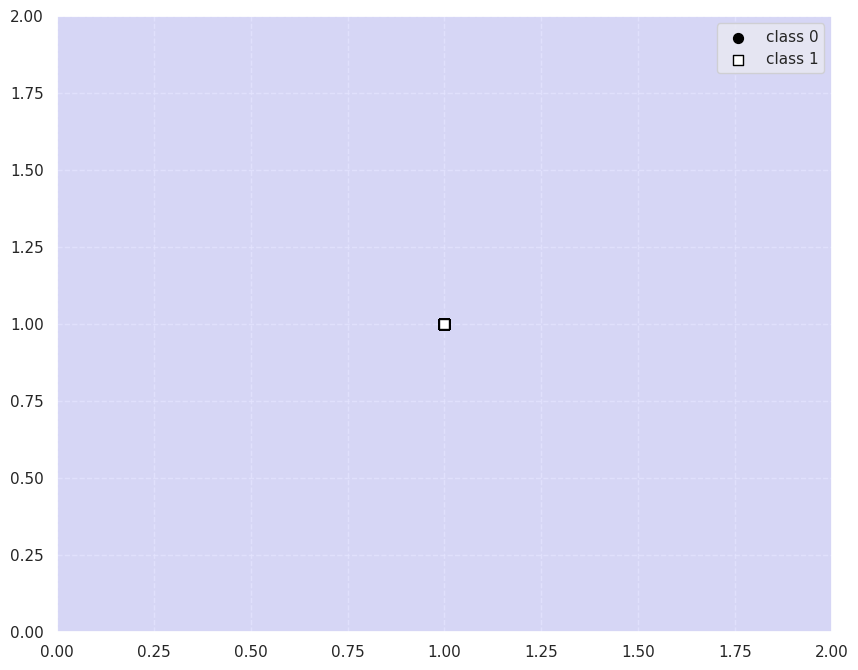

In [ ]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X_x, y_y)
plot_decision_boundary(model, X_x, y_y)

*Ну подытоживая - логрег у нас может найти только прямую линию, разделяющую классы. В нашем же случае точки невозможно как-либо разделить, то есть что и может дать нам логрег это 0.5*